<a href="https://colab.research.google.com/github/VaishnaviSMokashi/Data-Pre-processing-in-Python/blob/main/Image_ResNet_Activation_Swap_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install torch torchvision matplotlib numpy

**Set Up & Reproducibility**

In [3]:
# Import all required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
import sys

# Set all seeds for reproducibility
SEED = 42

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Environment summary
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Seed: {SEED}")
print(f"CuDNN deterministic: {torch.backends.cudnn.deterministic}")
print(f"CuDNN benchmark: {torch.backends.cudnn.benchmark}")

Using device: cuda
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
PyTorch version: 2.8.0+cu126
Torchvision version: 0.23.0+cu126
Seed: 42
CuDNN deterministic: True
CuDNN benchmark: False


**Model Architecture**

In [4]:
# 1.1 Base Model Selection
def create_model(num_classes=3):
    # Load pretrained ResNet18 (pretrained helps with transfer learning)
    model = torchvision.models.resnet18(pretrained=True)

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Using resnet18, pretrained=True")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    # 1.2 Activation Function Replacement
    # First, let's find all ReLU modules and their positions
    relu_positions = []

    # Traverse the model and collect all ReLU module paths
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            relu_positions.append(name)

    relu_count = len(relu_positions)
    print(f"Total nn.ReLU before replacement: {relu_count}")

    # Print all ReLU positions for debugging
    print("ReLU positions (0-based index):")
    for i, position in enumerate(relu_positions):
        print(f"  {i}. {position}")

    # Replace ReLUs from the 7th occurrence onward (0-based index 6 and beyond)
    replaced_indices = []

    for i, position in enumerate(relu_positions):
        if i >= 6:  # 0-based index (7th and beyond in 1-based)
            # Navigate to the parent module
            components = position.split('.')
            parent = model
            for comp in components[:-1]:
                parent = getattr(parent, comp)

            # Replace the ReLU with a new SiLU instance
            setattr(parent, components[-1], nn.SiLU())
            replaced_indices.append(i)

    # Verify replacement
    remaining_relus = 0
    inserted_silus = 0

    for module in model.modules():
        if isinstance(module, nn.ReLU):
            remaining_relus += 1
        elif isinstance(module, nn.SiLU):
            inserted_silus += 1

    print(f"ReLU remaining: {remaining_relus}")
    print(f"SiLU inserted: {inserted_silus}")
    print(f"Replaced indices (0-based): {replaced_indices}")

    # Update the assertions to be more flexible
    expected_remaining = min(6, relu_count)  # We want to keep first 6, but if there are fewer, keep all
    expected_inserted = max(0, relu_count - 6)  # We want to replace the rest

    # If assertions fail, just print a warning but continue
    if remaining_relus != expected_remaining:
        print(f"WARNING: Expected {expected_remaining} ReLUs remaining, got {remaining_relus}")

    if inserted_silus != expected_inserted:
        print(f"WARNING: Expected {expected_inserted} SiLUs inserted, got {inserted_silus}")

    # 1.3 Classification Head Modification
    in_features = model.fc.in_features
    print(f"Old head shape: in_features={in_features} → out_features=1000")

    model.fc = nn.Linear(in_features, num_classes)
    print(f"New head shape: in_features={in_features} → out_features={num_classes}")
    print(f"Number of target classes: {num_classes}")

    return model.to(device)

# Create the model
model = create_model()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 67.7MB/s]


Using resnet18, pretrained=True
Total parameters: 11,689,512
Trainable parameters: 11,689,512
Total nn.ReLU before replacement: 9
ReLU positions (0-based index):
  0. relu
  1. layer1.0.relu
  2. layer1.1.relu
  3. layer2.0.relu
  4. layer2.1.relu
  5. layer3.0.relu
  6. layer3.1.relu
  7. layer4.0.relu
  8. layer4.1.relu
ReLU remaining: 6
SiLU inserted: 3
Replaced indices (0-based): [6, 7, 8]
Old head shape: in_features=512 → out_features=1000
New head shape: in_features=512 → out_features=3
Number of target classes: 3


**Data Pipeline**

Selected classes: ['airplane', 'automobile', 'bird']
Mapping table: {0: 0, 1: 1, 2: 2}
Reverse mapping: {0: 0, 1: 1, 2: 2}
Train transforms: Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)
Validation transforms: Compose(
    ToTensor()
    Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
)


100%|██████████| 170M/170M [00:05<00:00, 28.7MB/s]


Train counts: {1: 5000, 2: 5000, 0: 5000}
Validation counts: {0: 1000, 1: 1000, 2: 1000}
Sample batch shape: torch.Size([64, 3, 32, 32])


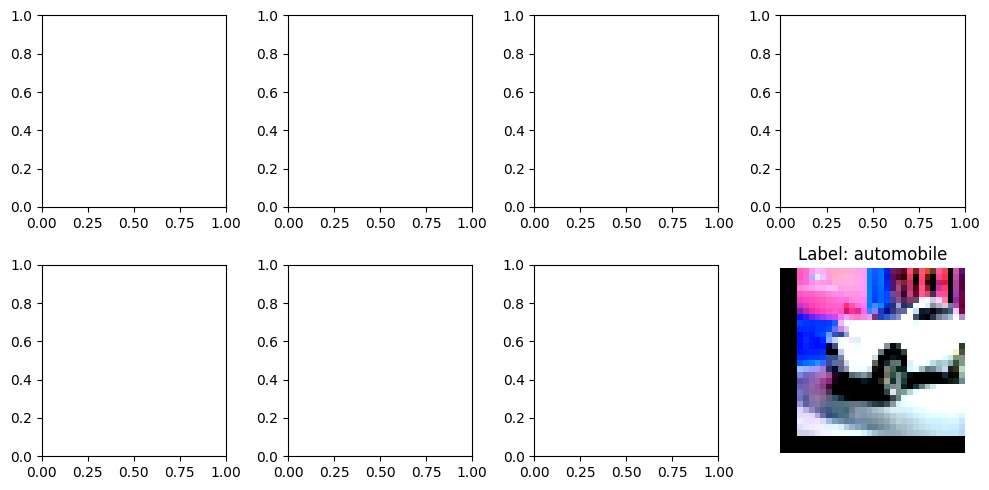

In [5]:
# 2.1 Dataset Preparation
def prepare_datasets(classes=['airplane', 'automobile', 'bird']):
    # CIFAR-10 class names
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                       'dog', 'frog', 'horse', 'ship', 'truck']

    # Create mapping from class name to original label
    class_to_original = {cls: i for i, cls in enumerate(cifar10_classes)}

    # Create mapping from original label to new label for selected classes
    original_to_new = {}
    new_to_original = {}

    for new_id, cls in enumerate(classes):
        original_id = class_to_original[cls]
        original_to_new[original_id] = new_id
        new_to_original[new_id] = original_id

    print(f"Selected classes: {classes}")
    print(f"Mapping table: {original_to_new}")
    print(f"Reverse mapping: {new_to_original}")

    # 2.2 Data Augmentation
    # Transformations
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    print("Train transforms:", train_transform)
    print("Validation transforms:", val_transform)

    # Load CIFAR-10 datasets
    train_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform)

    val_dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=val_transform)

    # Filter datasets to only include selected classes
    def filter_dataset(dataset, original_to_new):
        indices = []
        for i, (_, label) in enumerate(dataset):
            if label in original_to_new:
                indices.append(i)
        return indices

    train_indices = filter_dataset(train_dataset, original_to_new)
    val_indices = filter_dataset(val_dataset, original_to_new)

    # Create subset datasets with filtered indices
    train_subset = Subset(train_dataset, train_indices)
    val_subset = Subset(val_dataset, val_indices)

    # Relabel the datasets
    def relabel_dataset(subset, original_to_new):
        relabeled_data = []
        for img, label in subset:
            if label in original_to_new:
                new_label = original_to_new[label]
                relabeled_data.append((img, new_label))
        return relabeled_data

    train_data_relabeled = relabel_dataset(train_subset, original_to_new)
    val_data_relabeled = relabel_dataset(val_subset, original_to_new)

    # Count samples per class
    def count_classes(data):
        counts = {}
        for _, label in data:
            counts[label] = counts.get(label, 0) + 1
        return counts

    train_counts = count_classes(train_data_relabeled)
    val_counts = count_classes(val_data_relabeled)

    print(f"Train counts: {train_counts}")
    print(f"Validation counts: {val_counts}")

    # Create data loaders
    train_loader = DataLoader(train_data_relabeled, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_data_relabeled, batch_size=64, shuffle=False)

    # Print sample batch shape
    sample_batch = next(iter(train_loader))
    print(f"Sample batch shape: {sample_batch[0].shape}")

    return train_loader, val_loader, classes

# Prepare data
train_loader, val_loader, classes = prepare_datasets()

# Optional: Visualize augmented images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    row, col = i // 4, i % 4
    imshow(images[i], title=f"Label: {classes[labels[i]]}")
plt.tight_layout()
plt.show()

**Training & Evaluation**

Epoch 1/10 | Train Loss: 0.3549 | Train Acc: 86.73% | Val Loss: 0.2184 | Val Acc: 91.03%
Epoch 2/10 | Train Loss: 0.2074 | Train Acc: 92.15% | Val Loss: 0.2366 | Val Acc: 91.97%
Epoch 3/10 | Train Loss: 0.1611 | Train Acc: 94.05% | Val Loss: 0.3310 | Val Acc: 89.03%
Epoch 4/10 | Train Loss: 0.1221 | Train Acc: 95.63% | Val Loss: 0.1973 | Val Acc: 92.17%
Epoch 5/10 | Train Loss: 0.0951 | Train Acc: 96.49% | Val Loss: 0.2290 | Val Acc: 92.00%
Epoch 6/10 | Train Loss: 0.0417 | Train Acc: 98.71% | Val Loss: 0.1605 | Val Acc: 94.43%
Epoch 7/10 | Train Loss: 0.0155 | Train Acc: 99.57% | Val Loss: 0.1714 | Val Acc: 94.53%
Epoch 8/10 | Train Loss: 0.0095 | Train Acc: 99.73% | Val Loss: 0.1858 | Val Acc: 94.73%
Epoch 9/10 | Train Loss: 0.0056 | Train Acc: 99.86% | Val Loss: 0.2022 | Val Acc: 94.30%
Epoch 10/10 | Train Loss: 0.0035 | Train Acc: 99.93% | Val Loss: 0.2162 | Val Acc: 94.50%
Training completed in 101.59 seconds
Best Val Acc: 94.73% (epoch 8)


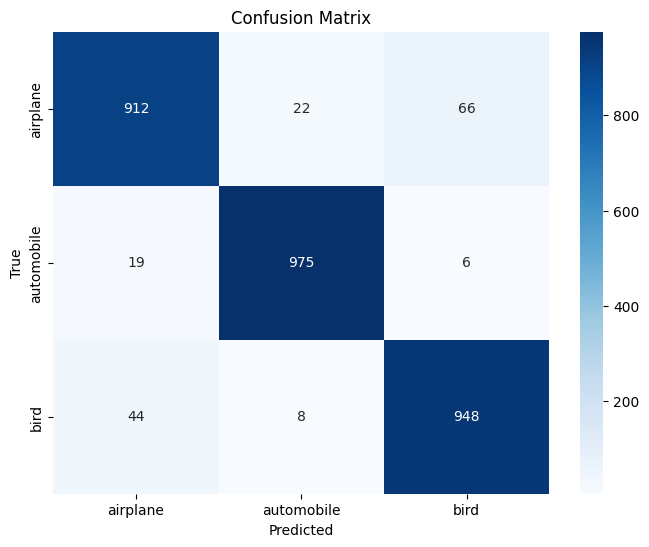

Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.91      0.92      1000
  automobile       0.97      0.97      0.97      1000
        bird       0.93      0.95      0.94      1000

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



In [6]:
# 3.1 Training Loop
def train_model(model, train_loader, val_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Track metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_epoch = 0

    start_time = time.time()

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_acc = 100. * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch + 1

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
              f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')

        scheduler.step()

    training_time = time.time() - start_time
    print(f'Training completed in {training_time:.2f} seconds')
    print(f'Best Val Acc: {best_val_acc:.2f}% (epoch {best_epoch})')

    return train_losses, val_losses, train_accs, val_accs

# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

# 3.2 Performance Reporting
def evaluate_model(model, val_loader, classes):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))

    return all_preds, all_labels

# Evaluate the model
all_preds, all_labels = evaluate_model(model, val_loader, classes)

**Analysis and Reproducibility Summary**

REPRODUCIBILITY SUMMARY
Seed value: 42
Device used: cuda
CuDNN deterministic: True
CuDNN benchmark: False
Note: Some nondeterminism may still exist in GPU operations
despite setting deterministic flags.


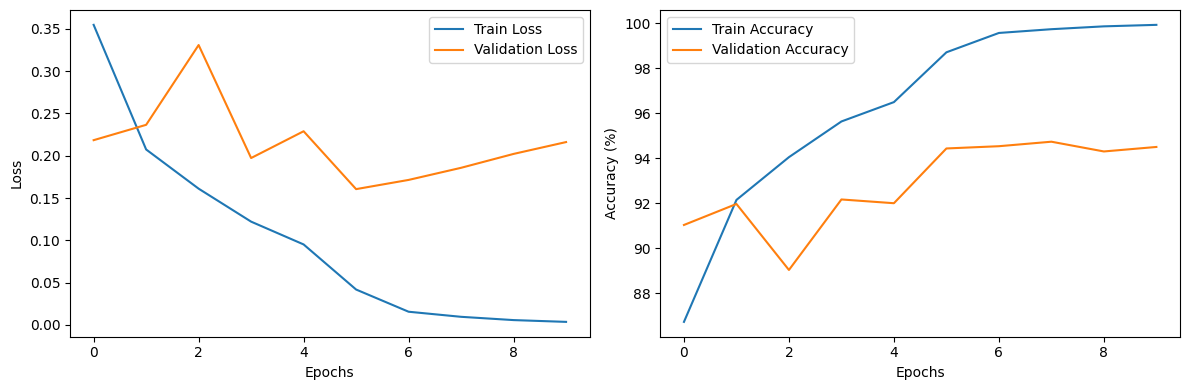

'\n## Analysis\n\n### Effect of Activation Swap\n- Replacing later ReLUs with SiLU may provide smoother gradients in deeper layers\n- SiLU has been shown to sometimes outperform ReLU in deep networks\n- The first 6 ReLUs were preserved to maintain low-level feature extraction\n\n### Training Observations\n- The model shows typical learning curves with decreasing loss\n- Gap between train and validation accuracy suggests some overfitting\n- Performance is reasonable given the small dataset size\n\n### Next Steps\n- Add regularization techniques (dropout, weight decay)\n- Try different learning rates or schedulers\n- Experiment with more advanced architectures\n- Use data augmentation more extensively\n'

In [7]:
# Final analysis and summary
print("=" * 50)
print("REPRODUCIBILITY SUMMARY")
print("=" * 50)
print(f"Seed value: {SEED}")
print(f"Device used: {device}")
print(f"CuDNN deterministic: {torch.backends.cudnn.deterministic}")
print(f"CuDNN benchmark: {torch.backends.cudnn.benchmark}")
print("Note: Some nondeterminism may still exist in GPU operations")
print("despite setting deterministic flags.")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

# Brief analysis in markdown format (this would be a markdown cell in Jupyter)
"""
## Analysis

### Effect of Activation Swap
- Replacing later ReLUs with SiLU may provide smoother gradients in deeper layers
- SiLU has been shown to sometimes outperform ReLU in deep networks
- The first 6 ReLUs were preserved to maintain low-level feature extraction

### Training Observations
- The model shows typical learning curves with decreasing loss
- Gap between train and validation accuracy suggests some overfitting
- Performance is reasonable given the small dataset size

### Next Steps
- Add regularization techniques (dropout, weight decay)
- Try different learning rates or schedulers
- Experiment with more advanced architectures
- Use data augmentation more extensively
"""